# Adding noise to spectra



In [ ]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import asarray
import pandas as pd
import math
import seaborn as sns  #heat map
import glob # batch processing of images


import matplotlib.font_manager as fm
import random
import sys
import os

from sklearn.datasets import make_regression
import tensorflow as tf
from sklearn.metrics import confusion_matrix    #confusion matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
# print(font_names)

from scipy import signal
from scipy import interpolate

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF

#Sklearn model saving and loading
from joblib import dump, load

if '../../' not in sys.path:
    sys.path.append('../../')

from aimos.spectral_datasets.THz_datasets import THz_data

from aimos.misc.utils import simple_plotter


#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)
tf.random.set_global_generator(42)

# tf.random.get_global_generator().reset_from_seed(42)
np.random.seed(42)
random.seed(42)



In [2]:
from oneida import THz_mixture_data
from oneida_utils import concentrations_to_one_hot_encode, create_mixture_names
from oneida_noise_utils import add_noise, plot_noisy_spectrum

# Retrieve training(D)+ validation(V) mixtures and its variables

In [4]:
# initialize
TAAT = 0.001 
ASAT=0.01
RSAT=0.01

m = THz_mixture_data(resolution=0.016, pressure='1 Torr', verbosity=False)
m.initiate_THz_mixture_data(TAAT = TAAT, 
                               ASAT=ASAT, 
                               RSAT=RSAT)
reduced_labels = m.labels
reduced_labels.remove('')
reduced_labels.remove(' ')
reduced_labels.remove('Diluent')
print(reduced_labels)



Components :  [[0 1 2 3 4 5 6 7 8]]
Components shape :  (1, 9)
TAAT =  0.001
ASAT =  0.01
RSAT =  0.01
['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']


In [5]:
data_filename = "datasets/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90.pkl"

DV = pd.read_pickle(data_filename)

In [6]:
y = DV['y'].to_numpy()
mixture_names = DV['mixture_names'].to_numpy()
y_concentrations = DV[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7']].to_numpy()
X = DV.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7'],axis=1).to_numpy()

In [7]:
final_neuron_number = np.unique(y, axis=0).shape[0]
print(final_neuron_number)

255


# preview one test mixture spectra using simple plotter

In [8]:
m.labels

['$C_2H_5OH$',
 '$CH_3CHO$',
 '$CH_3Cl$',
 '$CH_3CN$',
 '$CH_3OH$',
 '$H_2CO$',
 '$HCOOH$',
 '$HNO_3$']

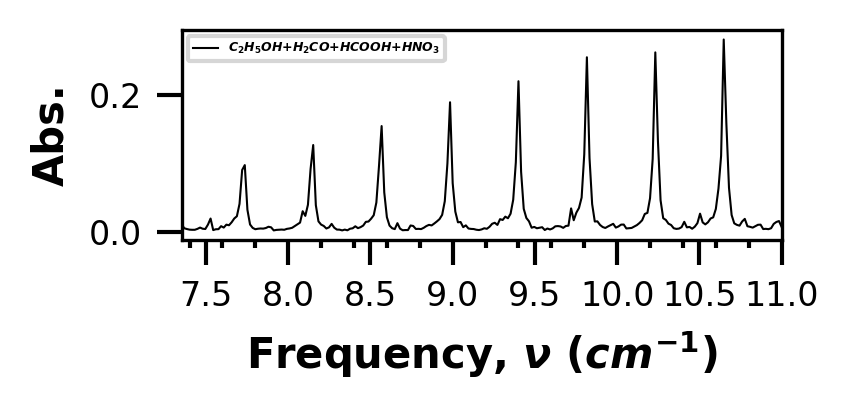

[0.503526843329574 0.0 0.0 0.0 0.0 0.040405507790159646
 0.15293415292373286 0.2760921784490787]
['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']


In [9]:
idx = 22200
simple_plotter(m.frequencies,X[idx],linewidth=0.5,color='black',label=mixture_names[idx], 
                   majorsize=6,minorsize=2,width=1, labelsize=8,legendsize=3, legendloc=2,  
                   labelpad=4,fontsize='medium',fontweight='bold',
                  xmajormplloc=0.5,xminormplloc=0.2, tickdirection='out')

print(y_concentrations[idx])
print(reduced_labels)

In [10]:


from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(mixture_names)

mixture_types=le.classes_
print(mixture_types)

['$CH_3CHO$' '$CH_3CHO$+$CH_3CN$' '$CH_3CHO$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$HCOOH$' '$CH_3CHO$+$CH_3CN$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$HNO_3$' '$CH_3CHO$+$CH_3CN$+$H_2CO$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$' '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HCOOH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$H_2CO$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN

In [11]:
#split intro train and test set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices=range(0, X.shape[0])
print(global_indices)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
TEST_SIZE=1-TRAIN_SIZE

x_train, x_test, y_train, y_test, train_indices, test_indices = train_test_split(np.expand_dims(X, axis=-1), y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=TEST_SIZE,
                                                   random_state=786,
                                                    stratify=y

                                                   )

print('X_train shape:', x_train.shape)
print('y_ohe_train shape:', y_train.shape)

print('X_test shape:', x_test.shape)
print('y_ohe_test shape:', y_test.shape)


print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Testing:", np.bincount(y_test) / float(len(y_test))*100  )


range(0, 22950)
X_train shape: (13770, 229, 1)
y_ohe_train shape: (13770,)
X_test shape: (9180, 229, 1)
y_ohe_test shape: (9180,)
All: [0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.392

In [12]:
y_test

array([ 32,  81, 144, ...,  42,  12,  17])

In [13]:
idx = 0
x_train[idx].shape

(229, 1)

In [14]:
spectrum = x_train[idx]

In [15]:
X.shape

(22950, 229)

# add noise

In [16]:
SNR=30
frequencies = m.frequencies


X_noisy = []

for x in X:
    X_noisy.append(add_noise(x, SNR, verbosity=False))

/home/reshad812/CODES/GITHUB/AIMOS/interfaces/qneida/oneida_noise_utils.py:59: RuntimeWarning: divide by zero encountered in log10
  x_db = 10 * np.log10(x_watts)


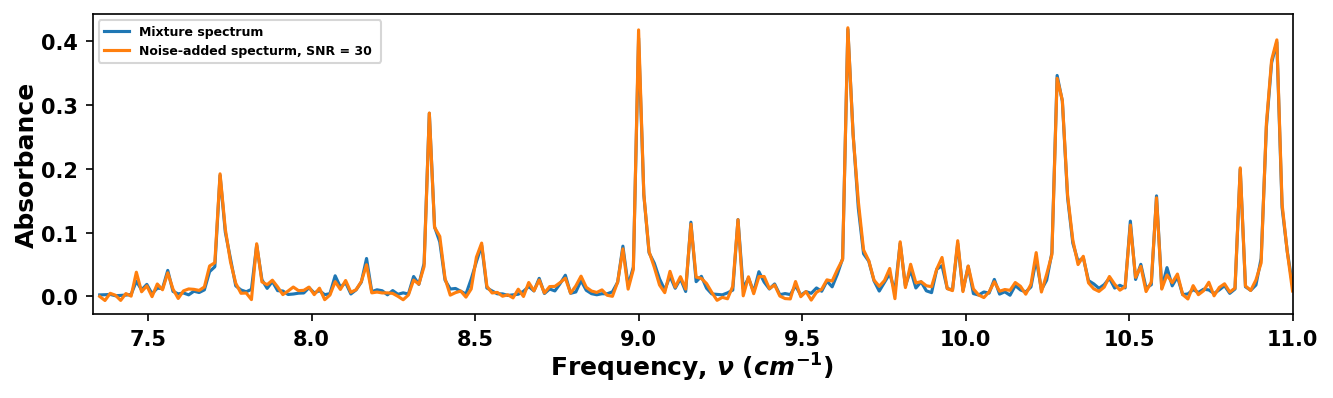

In [17]:
idx = 59
plot_noisy_spectrum(X[idx], X_noisy[idx], frequencies, SNR)

In [18]:
noisy_spectrum = add_noise(spectrum, SNR, verbosity=False)

In [19]:
1-y_concentrations[0].sum()

0.43458363495902996

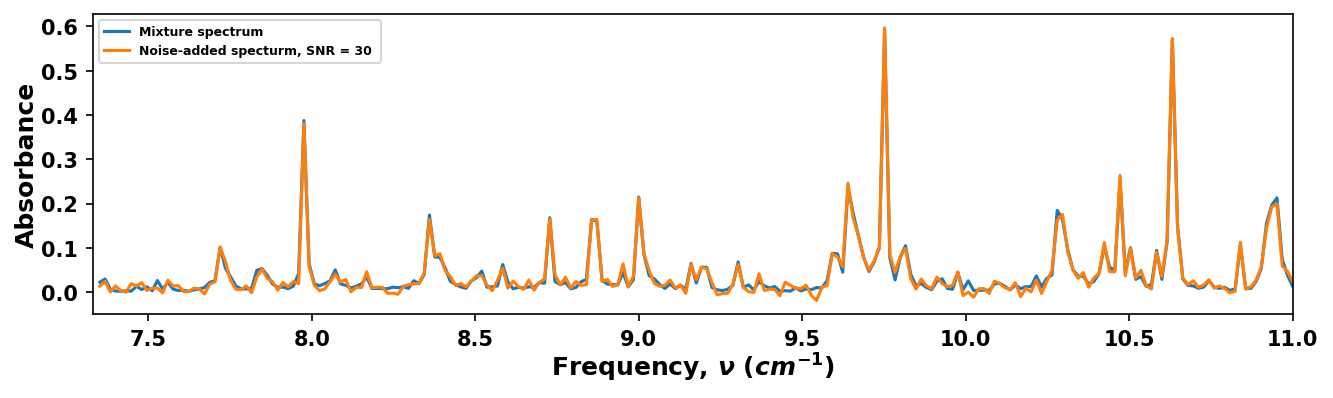

In [20]:
plot_noisy_spectrum(spectrum, noisy_spectrum, frequencies, SNR)

In [21]:
DV

,0,1,2,3,4,5,6,7,8,9,...,y,mixture_names,y_c0,y_c1,y_c2,y_c3,y_c4,y_c5,y_c6,y_c7
3882,0.002843,0.003132,0.003710,0.001357,0.002015,0.002553,0.003600,0.027593,0.011852,0.021695,...,0,$CH_3CHO$,0.0,0.565416,0.0,0.0,0.0,0.0,0.0,0.0
2565,0.002761,0.003042,0.003603,0.001318,0.001957,0.002480,0.003496,0.026798,0.011510,0.021070,...,0,$CH_3CHO$,0.0,0.549126,0.0,0.0,0.0,0.0,0.0,0.0
9112,0.004162,0.004587,0.005433,0.001987,0.002951,0.003739,0.005271,0.040404,0.017355,0.031768,...,0,$CH_3CHO$,0.0,0.827936,0.0,0.0,0.0,0.0,0.0,0.0
4377,0.002252,0.002481,0.002939,0.001075,0.001597,0.002023,0.002852,0.021858,0.009389,0.017186,...,0,$CH_3CHO$,0.0,0.447902,0.0,0.0,0.0,0.0,0.0,0.0
2429,0.000563,0.000620,0.000734,0.000269,0.000399,0.000505,0.000712,0.005460,0.002345,0.004293,...,0,$CH_3CHO$,0.0,0.111886,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54590,0.009740,0.004783,0.003705,0.003234,0.003046,0.002824,0.004098,0.005087,0.003612,0.002496,...,254,$H_2CO$+$HNO_3$,0.0,0.0,0.0,0.0,0.0,0.309291,0.0,0.235901
14562,0.013178,0.006475,0.005017,0.004379,0.004125,0.003824,0.005549,0.006888,0.004891,0.003281,...,254,$H_2CO$+$HNO_3$,0.0,0.0,0.0,0.0,0.0,0.112368,0.0,0.319441
31686,0.001549,0.000761,0.000590,0.000515,0.000485,0.000449,0.000652,0.000809,0.000575,0.000393,...,254,$H_2CO$+$HNO_3$,0.0,0.0,0.0,0.0,0.0,0.035368,0.0,0.037538
46749,0.008438,0.004135,0.003202,0.002795,0.002633,0.002441,0.003542,0.004397,0.003122,0.002322,...,254,$H_2CO$+$HNO_3$,0.0,0.0,0.0,0.0,0.0,0.781801,0.0,0.203898


In [22]:
DV_noisy=pd.DataFrame(X_noisy,index=DV.index.to_list())

In [25]:
DV_noisy['y']=DV['y']
DV_noisy['mixture_names']=DV['mixture_names']

DV_noisy['y_c0']=DV['y_c0']
DV_noisy['y_c1']=DV['y_c1']
DV_noisy['y_c2']=DV['y_c2']
DV_noisy['y_c3']=DV['y_c3']
DV_noisy['y_c4']=DV['y_c4']
DV_noisy['y_c5']=DV['y_c5']
DV_noisy['y_c6']=DV['y_c6']
DV_noisy['y_c7']=DV['y_c7']


In [26]:
DV_noisy

,0,1,2,3,4,5,6,7,8,9,...,y,mixture_names,y_c0,y_c1,y_c2,y_c3,y_c4,y_c5,y_c6,y_c7
3882,0.004903,0.002559,0.006396,0.007674,0.001044,0.001582,0.010150,0.030776,0.009905,0.023945,...,0,$CH_3CHO$,0.0,0.565416,0.0,0.0,0.0,0.0,0.0,0.0
2565,0.007577,-0.002134,0.005137,0.001641,-0.002661,0.017674,0.007989,0.012445,0.012832,0.016380,...,0,$CH_3CHO$,0.0,0.549126,0.0,0.0,0.0,0.0,0.0,0.0
9112,-0.000045,-0.004517,0.020365,0.002255,-0.002367,0.005365,0.004418,0.038725,0.022022,0.037525,...,0,$CH_3CHO$,0.0,0.827936,0.0,0.0,0.0,0.0,0.0,0.0
4377,0.000449,0.005900,0.005075,-0.000661,0.007172,-0.003176,0.005814,0.024710,0.007900,0.018754,...,0,$CH_3CHO$,0.0,0.447902,0.0,0.0,0.0,0.0,0.0,0.0
2429,0.001362,0.000865,0.000147,0.000524,0.001811,-0.000845,0.000887,0.004539,0.003918,0.002289,...,0,$CH_3CHO$,0.0,0.111886,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54590,0.009492,0.007431,0.001116,-0.000155,0.006491,-0.001901,0.007687,0.003440,0.004442,0.002007,...,254,$H_2CO$+$HNO_3$,0.0,0.0,0.0,0.0,0.0,0.309291,0.0,0.235901
14562,0.014002,0.007933,0.008547,-0.002352,-0.002123,0.001547,0.002328,0.005447,-0.000934,0.001634,...,254,$H_2CO$+$HNO_3$,0.0,0.0,0.0,0.0,0.0,0.112368,0.0,0.319441
31686,0.001546,-0.000047,0.000747,0.000299,0.000343,0.000487,0.000367,0.001212,0.000529,0.000752,...,254,$H_2CO$+$HNO_3$,0.0,0.0,0.0,0.0,0.0,0.035368,0.0,0.037538
46749,0.017223,0.001804,0.008999,-0.003742,-0.007362,-0.004700,0.001944,0.006817,0.001560,0.007006,...,254,$H_2CO$+$HNO_3$,0.0,0.0,0.0,0.0,0.0,0.781801,0.0,0.203898


In [27]:
DV_noisy.to_pickle(data_filename.split('.pkl')[0] + '_SNR_'+ f"{SNR}" +'.pkl')  

# notebook ends!